In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping,ModelCheckpoint
from scipy import signal
import os 
import pandas as pd
import wandb
from wandb.keras import WandbCallback

2023-12-18 18:29:25.798779: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-18 18:29:25.846951: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-18 18:29:25.846980: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-18 18:29:25.847014: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-18 18:29:25.856778: I tensorflow/core/platform/cpu_feature_g

## Data Loading

In [2]:
x_train=np.load('../BraiNeoCare/Datasets/balanced_x_train_common_4s.npy', mmap_mode='r')[0:10000,...]
x_test=np.load('../BraiNeoCare/Datasets/balanced_x_test_common_4s.npy', mmap_mode='r')
y_train=np.load('../BraiNeoCare/Datasets/balanced_y_train_common_4s.npy', mmap_mode='r')[0:10000,...]
y_test=np.load('../BraiNeoCare/Datasets/balanced_y_test_common_4s.npy', mmap_mode='r')

In [3]:
# sos=signal.butter(2,[0.5,100],btype='bandpass',fs=256,output='sos')    

In [4]:
# x_train=signal.sosfilt(sos,x_train,axis=1)
# x_test=signal.sosfilt(sos,x_test,axis=1)

In [3]:
mean=x_train.mean()
std=x_train.std()
x_train=(x_train-mean)/std
x_test=(x_test-mean)/std

In [4]:
#shuffle the data
np.random.seed(42)
train_indices = np.arange(x_train.shape[0])
np.random.shuffle(train_indices)
x_train = x_train[train_indices].reshape(x_train.shape[0],1024,12)
y_train = y_train[train_indices]
test_indices = np.arange(x_test.shape[0])   
np.random.shuffle(test_indices)
x_test = x_test[test_indices].reshape(x_test.shape[0],1024,12)
y_test = y_test[test_indices]

In [ ]:
# x_train=x_train*(10**5)
# x_test=x_test*(10**5)

## Tiny model

In [7]:
'''For 4s partitions I used dropout=0.25, and learning rate=0.0025, and weight decay=0.01. Saved model is best_model_for_4s_1.h5 was taken
after 500 epoch with batch size=128'''


Input=keras.Input(shape=(1024,12),name="Input_signal")
x=layers.Conv1D(32,3,padding="same",activation='swish')(Input)
y=layers.Conv1D(32,5,padding='same',activation='swish')(Input)
a=layers.add([x,y])
x=layers.MaxPooling1D(4)(a)
x=layers.SpatialDropout1D(0.25)(x) 

x=layers.Conv1D(64,3,padding="same",activation='swish')(x)   
y=layers.Conv1D(64,5,padding='same',activation='swish')(x)#new
a=layers.add([x,y])#new


x=layers.GlobalAveragePooling1D()(a)
x=layers.Dropout(0.25)(x)
x=layers.Dense(32,activation='swish')(x) 
x=layers.Dense(16,activation='swish')(x)
x=layers.Dense(1,activation='sigmoid')(x)

model1=keras.Model(inputs=Input,outputs=x)

optimizer=keras.optimizers.Adam(learning_rate=0.0025,weight_decay=0.01)
 

F1 = keras.metrics.FBetaScore()
AUROC = keras.metrics.AUC(curve='ROC', name = 'AUROC')
AUPRC = keras.metrics.AUC(curve='PR', name = 'AUPRC')
model1.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy', F1, AUROC, AUPRC])

2023-12-17 15:17:26.620586: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14947 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:17:00.0, compute capability: 7.5
2023-12-17 15:17:26.621306: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14946 MB memory:  -> device: 1, name: Quadro RTX 5000, pci bus id: 0000:73:00.0, compute capability: 7.5


In [19]:
model1.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input_signal (InputLayer)   [(None, 1024, 12)]           0         []                            
                                                                                                  
 conv1d_8 (Conv1D)           (None, 1024, 32)             1184      ['Input_signal[0][0]']        
                                                                                                  
 conv1d_9 (Conv1D)           (None, 1024, 32)             1952      ['Input_signal[0][0]']        
                                                                                                  
 add_4 (Add)                 (None, 1024, 32)             0         ['conv1d_8[0][0]',            
                                                                     'conv1d_9[0][0]']      

In [8]:
checkpoint_path='Saved_model_weights_1/cp_{epoch:04d}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

In [9]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, mode='max',)
cp_callback = ModelCheckpoint(filepath=checkpoint_path,monitor="val_loss",save_weights_only=False,verbose=1,save_best_only=True)

history=model1.fit(x_train,y_train,epochs=500,batch_size=128,validation_data=(x_test,y_test))

Epoch 1/500


2023-12-17 15:17:30.429441: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-12-17 15:17:33.580617: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f925c028460 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-17 15:17:33.580649: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 5000, Compute Capability 7.5
2023-12-17 15:17:33.580655: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): Quadro RTX 5000, Compute Capability 7.5
2023-12-17 15:17:33.585851: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-17 15:17:33.734451: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


79/79 [==============================] - 10s 35ms/step - loss: 0.6433 - accuracy: 0.6255 - fbeta_score: 0.7455 - AUROC: 0.6375 - AUPRC: 0.7329 - val_loss: 0.6207 - val_accuracy: 0.6427 - val_fbeta_score: 0.6667 - val_AUROC: 0.7385 - val_AUPRC: 0.7517
Epoch 2/500
79/79 [==============================] - 2s 20ms/step - loss: 0.5844 - accuracy: 0.6789 - fbeta_score: 0.7455 - AUROC: 0.7452 - AUPRC: 0.8136 - val_loss: 0.5709 - val_accuracy: 0.6814 - val_fbeta_score: 0.6667 - val_AUROC: 0.7641 - val_AUPRC: 0.7871
Epoch 3/500
79/79 [==============================] - 2s 21ms/step - loss: 0.5658 - accuracy: 0.6987 - fbeta_score: 0.7455 - AUROC: 0.7630 - AUPRC: 0.8271 - val_loss: 0.5595 - val_accuracy: 0.7010 - val_fbeta_score: 0.6667 - val_AUROC: 0.7873 - val_AUPRC: 0.8005
Epoch 4/500
79/79 [==============================] - 2s 20ms/step - loss: 0.5449 - accuracy: 0.7129 - fbeta_score: 0.7455 - AUROC: 0.7817 - AUPRC: 0.8441 - val_loss: 0.5597 - val_accuracy: 0.6956 - val_fbeta_score: 0.6667 - v

In [16]:
model1.save('best_model_for_4s_1.h5')

/home/nima/miniconda3/envs/BrainNeoCare/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [17]:
with open("history_for_4s_best_1.jason", 'w') as f:
    pd.DataFrame(history.history).to_json(f)

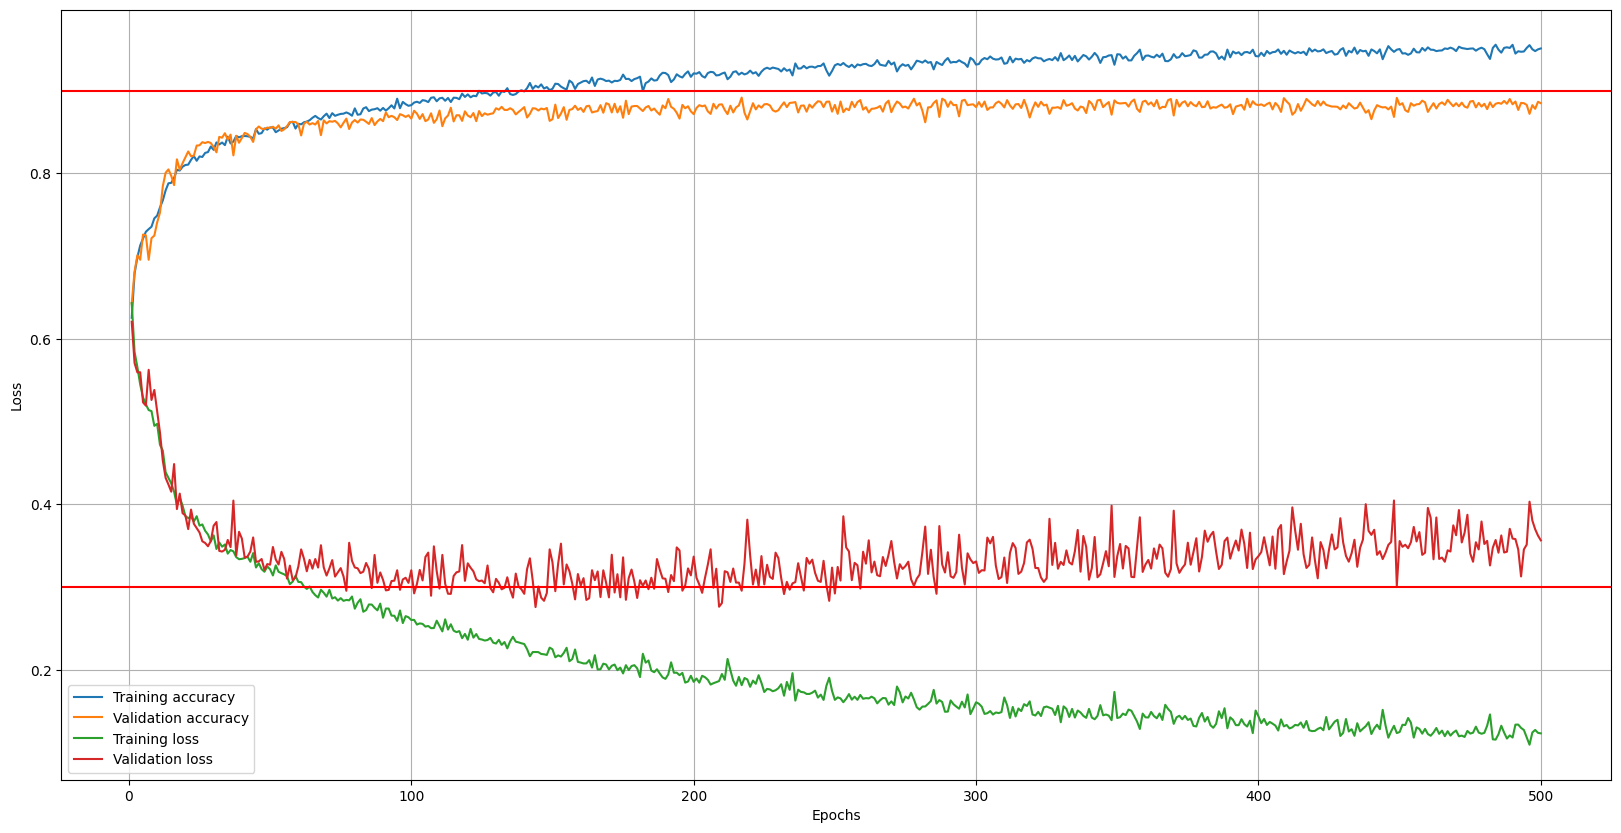

In [10]:
# Plot the training and validation loss and accuracy for each epoch for 1s partitions

training_accuracy = history.history['accuracy']
val_accuracy=history.history['val_accuracy']
training_loss = history.history['loss']
val_loss=history.history['val_loss']
epochs = range(1, len(training_accuracy) + 1)

# Plot training loss against epochs
plt.figure(figsize=(20, 10))
plt.plot(epochs, training_accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.plot(epochs, training_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.axhline(y=0.9, color='r', linestyle='-')
plt.axhline(y=0.3, color='r', linestyle='-')

plt.grid()
# plt.ylim(0,1)
# plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

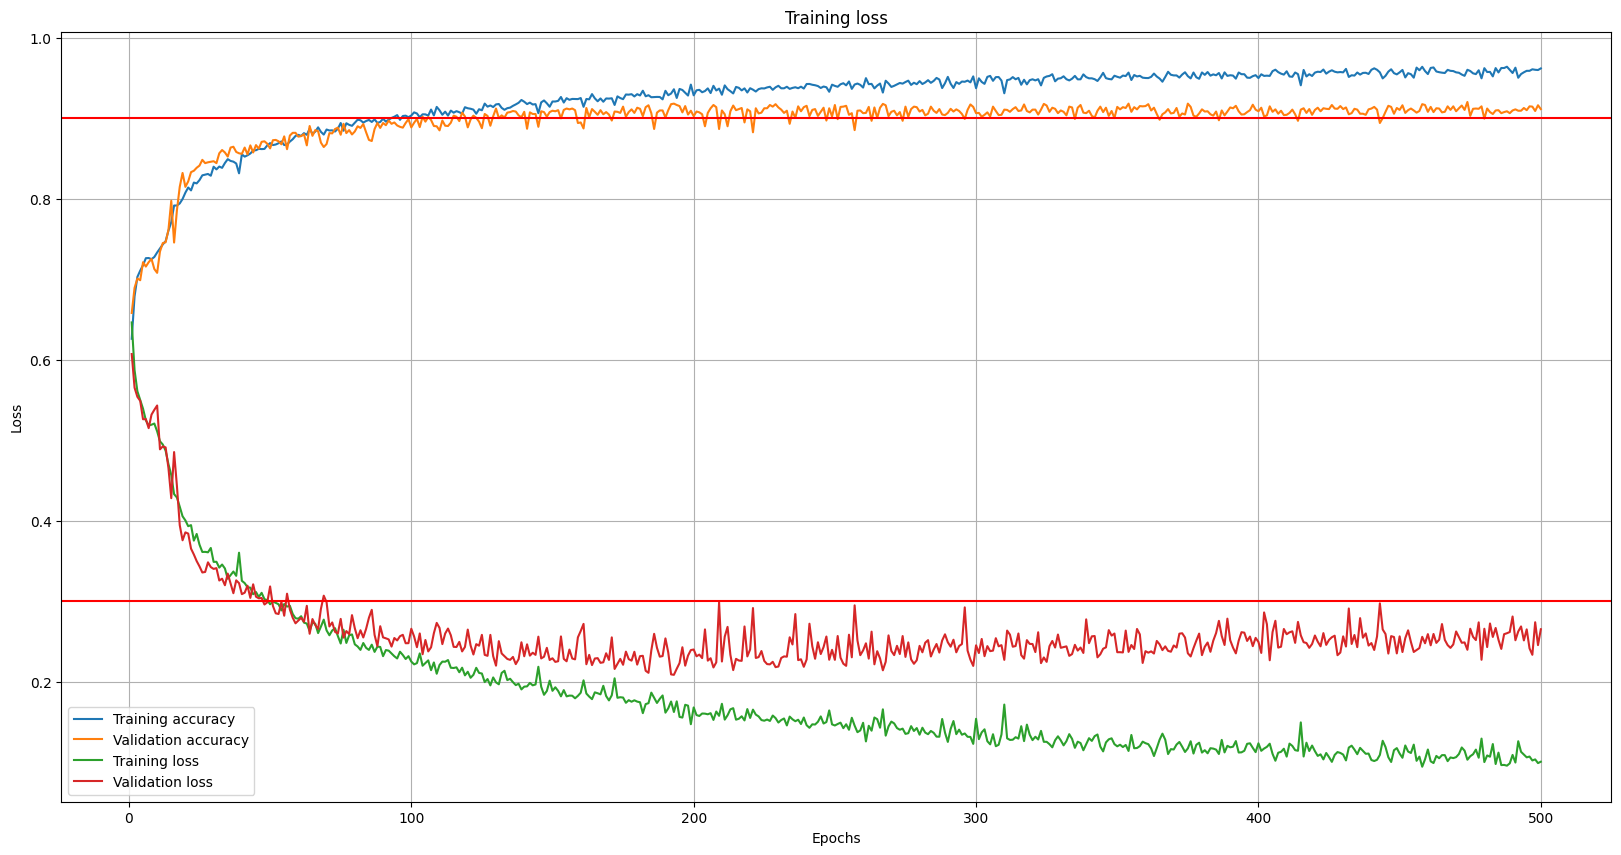

In [42]:
# Plot the training and validation loss and accuracy for each epoch for 4s partitions
with open('history_for_4s_best_1.jason','r') as f:
    history_1 = pd.read_json(f)

training_accuracy = history_1['accuracy']
val_accuracy=history_1['val_accuracy']
training_loss = history_1['loss']
val_loss=history_1['val_loss']
epochs = range(1, len(training_accuracy) + 1)

# Plot training loss against epochs
plt.figure(figsize=(20, 10))
plt.plot(epochs, training_accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.plot(epochs, training_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')

plt.axhline(y=0.3, color='r', linestyle='-')

plt.axhline(y=0.9, color='r', linestyle='-')
plt.grid()
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## wandb

In [ ]:
sweep_config = {
    'method': 'bayes',
    'metric': {
      'name': 'val_loss',
      'goal': 'minimize'
    },
    'parameters': {
        'batch_size': {
            'values': [256, 128, 64, 32]
        },
        'dropout': {
            'values': [0.2, 0.25, 0.3, 0.5, 0.7]
        },
        'spatdropout': {
            'values': [0.1, 0.2,0.25, 0.3,0.5]
        },
        'learning_rate': {
            'values': [ 0.001,0.002,0.0025, 0.005,0.01,0.1]
        },
        'weight_decay': {
            'values': [0.001,0.002,0.0025, 0.005,0.01,0.1]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'sgd', 'rmsprop']
        },
        'activation': {
            'values': ['relu', 'elu', 'selu', 'softmax', 'swish']
        }
    }
}

sweep_id = wandb.sweep(sweep_config, project="BraiNeoCare_testing")

def model_train():

    config_defaults = {
        'batch_size': 128,
        'dropout': 0.25,
        'spatdropout': 0.25,
        'learning_rate': 0.0025,
        'weight_decay': 0.01,
        'optimizer': 'adam',
        'activation': 'relu'

    }
    wandb.init(config=config_defaults)
    config = wandb.config

    Input=keras.Input(shape=(1024,12),name="Input_signal")
    x=layers.Conv1D(32,3,padding="same",activation=config.activation)(Input)
    y=layers.Conv1D(32,5,padding='same',activation=config.activation)(Input)
    a=layers.add([x,y])
    x=layers.MaxPooling1D(4)(a)
    x=layers.SpatialDropout1D(config.spatdropout)(x) 

    x=layers.Conv1D(64,3,padding="same",activation=config.activation)(x)   
    y=layers.Conv1D(64,5,padding='same',activation=config.activation)(x)
    a=layers.add([x,y])


    x=layers.GlobalAveragePooling1D()(a)
    x=layers.Dropout(config.dropout)(x)
    x=layers.Dense(32,activation=config.activation)(x) 
    x=layers.Dense(16,activation=config.activation)(x)
    x=layers.Dense(1,activation='sigmoid')(x)

    model1=keras.Model(inputs=Input,outputs=x)

    if config.optimizer=='adam':
        optimizer=keras.optimizers.Adam(learning_rate=config.learning_rate,weight_decay=config.weight_decay)
    elif config.optimizer=='nadam':
        optimizer=keras.optimizers.Nadam(learning_rate=config.learning_rate,weight_decay=config.weight_decay)
    elif config.optimizer=='sgd':
        optimizer=keras.optimizers.SGD(learning_rate=config.learning_rate,weight_decay=config.weight_decay)
    elif config.optimizer=='rmsprop':
        optimizer=keras.optimizers.RMSprop(learning_rate=config.learning_rate,weight_decay=config.weight_decay)

    F1 = keras.metrics.FBetaScore()
    AUROC = keras.metrics.AUC(curve='ROC', name = 'AUROC')
    AUPRC = keras.metrics.AUC(curve='PR', name = 'AUPRC')
    model1.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy', F1, AUROC, AUPRC])

    model1.fit(x_train,y_train,epochs=500,batch_size=config.batch_size,validation_data=(x_test,y_test),callbacks=[WandbCallback()],verbose=0)

wandb.agent(sweep_id, model_train)

## Working large model

In [ ]:
def block_type1(n_filters1,n_filters2, kernel, pad, x):
    block1=layers.Conv1D(n_filters1,kernel,padding=pad,activation='swish')(x)
    block1=layers.BatchNormalization()(block1)
    block1=layers.Conv1D(n_filters1,kernel,padding=pad,activation='swish')(block1)
    block1=layers.SpatialDropout1D(0.2)(block1)
    block1=layers.Conv1D(n_filters1,kernel,padding=pad,activation='swish')(block1)
    block1=layers.BatchNormalization()(block1)
    block1=layers.Conv1D(n_filters1,kernel,padding=pad,activation='swish')(block1)
    block1=layers.Conv1D(n_filters2,kernel,padding=pad,activation='swish')(block1)
    block1=layers.BatchNormalization()(block1)

    block1_o=layers.Conv1D(n_filters2,kernel,padding=pad,activation='swish')(x)
    block1_o=layers.BatchNormalization()(block1_o)
    added1=layers.add([block1,block1_o])
    return layers.Conv1D(n_filters2,kernel,padding=pad,activation='swish')(added1)

def block_type2(n_filters1,n_filters2, kernel, pad, x):
    block=layers.Conv1D(n_filters1,kernel,padding=pad,activation='swish')(x)
    block=layers.BatchNormalization()(block)
    block=layers.Conv1D(n_filters1,kernel,padding=pad,activation='swish')(block)
    block=layers.SpatialDropout1D(0.2)(block)
    block=layers.Conv1D(n_filters1,kernel,padding=pad,activation='swish')(block)
    block=layers.BatchNormalization()(block)
    block=layers.Conv1D(n_filters1,kernel,padding=pad,activation='swish')(block)
    block=layers.Conv1D(n_filters2,kernel,padding=pad,activation='swish')(block)
    block=layers.BatchNormalization()(block)

    added=layers.add([x,block])
    return layers.Conv1D(n_filters2,kernel,padding=pad,activation='swish')(added)

In [ ]:
def create_model():
  Input=keras.Input(shape=(256,12),name="Input_signal")
  x=layers.Conv1D(32,3,padding="same",activation='swish')(Input)
  y=layers.Conv1D(32,5,padding='same',activation='swish')(Input)
  a=layers.add([x,y])
  # x=layers.AveragePooling1D(2)(a)
  a=layers.SpatialDropout1D(0.2)(a) # was not here before
  x=layers.MaxPooling1D(4)(a)

  x1=block_type1(32,128,3,"same",x)
  x1=layers.SpatialDropout1D(0.2)(x1) 
  x2=block_type2(32,128,13,"same",x1)
  x2=layers.SpatialDropout1D(0.2)(x2)
  x3=block_type2(32,128,23,"same",x2)
  x3=layers.AveragePooling1D(4)(x3)
  x4=block_type1(64,256,7,"same",x3)
  x4=layers.SpatialDropout1D(0.2)(x4)
  x5=block_type2(64,256,17,"same",x4)
  x5=layers.SpatialDropout1D(0.2)(x5)
  x6=block_type2(64,256,27,"same",x5)
  x6=layers.SpatialDropout1D(0.2)(x6)
  x7=block_type2(64,256,7,"same",x6)
  x16=layers.GlobalAveragePooling1D()(x6)
  x16=layers.Dense(128)(x16) #previous 256
  x16=layers.Dropout(0.2)(x16) #previous 0.5
  x16=layers.Dense(16,activation='swish')(x16)
  x16=layers.Dense(1,activation='sigmoid')(x16)

  model=keras.Model(Input,x16)
  
  F1 = keras.metrics.FBetaScore()
  AUROC = keras.metrics.AUC(curve='ROC', name = 'AUROC')
  AUPRC = keras.metrics.AUC(curve='PR', name = 'AUPRC')

  # used the followiing one to get 0.99 accuracy for 4s data
  # model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy', F1, AUROC, AUPRC])

  optimizer=keras.optimizers.Adam(learning_rate=0.001,weight_decay=0.0002)
  loss=keras.losses.BinaryCrossentropy(from_logits=False)
  model.compile(optimizer=optimizer,loss=loss,metrics=['accuracy', F1, AUROC, AUPRC])
  
  # keras.utils.plot_model(model,'model.png',show_layer_activations=True,show_shapes=True)
  model.summary()
  return model

model = create_model()


In [ ]:
# used 128 as the batch size for 4s data
history=model.fit(x_train,y_train, validation_data = (x_test,y_test), epochs=100,batch_size=128)

In [ ]:
model.save('../BraiNeoCare/models/model1.h5')   

In [ ]:
training_accuracy = history.history['accuracy']
val_accuracy=history.history['val_accuracy']
training_loss = history.history['loss']
val_loss=history.history['val_loss']
epochs = range(1, len(training_accuracy) + 1)

# Plot training loss against epochs
# plt.figure(figsize=(6, 6))
plt.plot(epochs, training_accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.plot(epochs, training_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()